In [26]:
import json
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk import word_tokenize
from torch.nn.utils.rnn import pad_sequence
import torch
from torch.nn import Embedding
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
def parse_data(file):
    for l in open(file, 'r'):
        yield json.loads(l)
        
data1 = pd.DataFrame(parse_data('..Sarcasm_Headlines_Dataset_v2.json'))
data2 = pd.DataFrame(parse_data('...Sarcasm_Headlines_Dataset.json')) #add your own personal directory here
data = pd.concat([data1, data2]) #The Dataset comes in the form of these two files and can be located on Kaggle (too big for Git push), I would reccomend using both as each dataset is biased but similar results are obtainable on just one dataset

In [3]:
data.columns = ['Sarcastic', 'Headline', 'Link']
data.head(5) #To simply interpretation, a little bit of data cleaning

,Sarcastic,Headline,Link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
stop_words_removed = []
for i in data['Headline']:
    i = re.sub(r"[^a-zA-Z\s]", "", i)
    main_words = ' '.join([j for j in i.split() if j.lower() not in ENGLISH_STOP_WORDS])
    stop_words_removed.append(main_words)
    
tokenized_corpus = [word_tokenize(i) for i in stop_words_removed]
vocab = set([word for sentence in tokenized_corpus for word in sentence])
word_to_idx = {word: i for i, word in enumerate(vocab)}

#Relatively simple script for tokenization and word cleaning
#Sarcasm is sensitive to minute details in sentence structure, we want to make the data trainable while removing as little as possible

In [5]:
ttsplit = 0.2
max_length = 25 #Number previously derived from tuning

tokenized_corpus_num = []
for headline in tokenized_corpus:
    idx_seq = []
    for word in headline:
        idx_seq.append(word_to_idx[word])
    tokenized_corpus_num.append(idx_seq)

tensor_corpus = [torch.tensor(seq, dtype = torch.long) for seq in tokenized_corpus_num]
padded_sequences = pad_sequence(tensor_corpus, batch_first=True,padding_value=len(vocab))
padded_sequences = padded_sequences[:, :max_length]

sarcasm = torch.tensor(data['Sarcastic'].values, dtype = torch.long)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, sarcasm, test_size = ttsplit,
                                                    stratify = sarcasm, shuffle = True)

#No cross-validation set is needed as I have already tuned the hyperparameters in another dataset, this allows us to rescue more data
#Cross-validation should be repeated if you choose to undergo data augmentation or add more data from elsewhere


In [6]:
embeddings_index = {}
embedding_dim = 100

GloVe = open(os.path.join(os.getcwd(), 'glove.twitter.27B.100d.txt'), encoding = "utf-8")

for entry in GloVe:
    values = entry.split()
    word = values[0]
    coeffs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coeffs
GloVe.close()

#Data is publically available online as weights in txt format (too big for Git)

In [7]:
embedding_matrix = np.zeros((len(word_to_idx) + 1, embedding_dim))
c = 0
for word, i in word_to_idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector

#Indexing the embedded words for numerical representation in PyTorch

In [11]:
vocab_size = len(word_to_idx) + 1
class SarcasmLSTM(nn.Module): #PyTorch class inheritance for Sarcasm LSTM to layer above embeddings
    def __init__(self, embedding_matrix, hidden_dim = 64, rdropout = 0.25):
        super().__init__()
        
        self.embedding_weights = torch.tensor(embedding_matrix, dtype = torch.float32)
        self.embedding_layer = Embedding.from_pretrained(self.embedding_weights, freeze = True, padding_idx=len(vocab))

    
        self.lstm = nn.LSTM(input_size = 100, hidden_size = hidden_dim,
                            batch_first=True, dropout=rdropout,
                            bidirectional = True)
        
        self.fc = nn.Linear(hidden_dim*2, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x): #Mandatory forward function
        x = self.embedding_layer(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
        
class SarcasmDataset(Dataset): #This function is not necessary, solely for simplicity in creating a Tensor
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    
train_dataset = SarcasmDataset(X_train, y_train) #Datasets for testing and training
test_dataset = SarcasmDataset(X_test, y_test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True) #Data Loaders for PyTorch
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

In [ ]:
model2 = SarcasmLSTM(embedding_matrix = embedding_matrix)
device = torch.device("cpu")

criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr = 0.001) #Model training
num_epochs = 30

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model2.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.numel()
            
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    accuracy = correct / total
    
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model2(inputs)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)        
    
    
    print(f"Epoch [{epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Test Loss: {avg_test_loss:.4f} Accuracy: {accuracy}]")
    
torch.save(model2.state_dict(), "sarcasm_lstm_GloVe2.pth")
print('Model Saved!')

#Run this block to train the model!

In [ ]:
model_path = os.getcwd() + '\\sarcasm_lstm_GloVe2.pth' #no need to run this unless you are using the pretrained model that I left in the repo
model_GloVe = SarcasmLSTM(embedding_matrix=embedding_matrix)

model_GloVe.load_state_dict(torch.load(model_path, map_location = "cpu")) #Change if applicable
model_GloVe.to("cpu")

In [23]:
#This function is only here for debugging and verifying the tuning
#The data stored for the graphs is done by the training loop

def evaluate_model(loader, model, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
        
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to("cpu"), labels.to("cpu").float().unsqueeze(1)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.numel() 
            
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
        
    return avg_loss, accuracy

In [ ]:
evaluate_model(test_loader, model_GloVe, criterion)

#This model should be about 95.3% accurate on average!

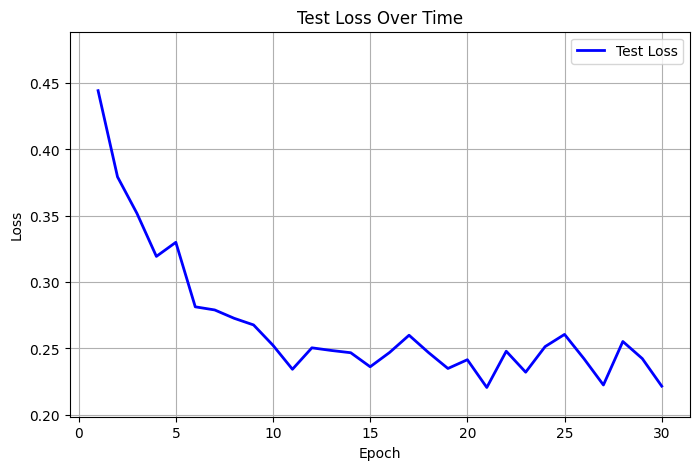

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss", color="blue", linewidth=2)

plt.ylim(min(test_losses) * 0.9, max(test_losses) * 1.1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

#This graph is shown in the repo as well, yours will look slightly different
